Embedding and Positional Encoding

In [1]:
import math
import torch
import torch.nn as nn

class EmbeddingWithProjection(nn.Module):
    """
    This module handles the input embedding layer for the Transformer.
    It maps input token indices to dense vectors, projects them to the model dimension,
    adds sinusoidal positional encodings, and applies LayerNorm and dropout.
    """

    def __init__(self, vocab_size, d_embed, d_model,
                 max_position_embeddings=512, dropout=0.1):
        """
        Initializes token embedding, linear projection to d_model,
        positional encoding prep, and normalization layers.
        """
        super().__init__()
        self.d_model = d_model
        self.d_embed = d_embed
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.projection = nn.Linear(self.d_embed, self.d_model)
        self.scaling = float(math.sqrt(self.d_model))

        self.layernorm = nn.LayerNorm(self.d_model)
        self.dropout = nn.Dropout(p=dropout)

    @staticmethod
    def create_positional_encoding(seq_length, d_model, batch_size=1):
        """
        Generates fixed sinusoidal positional encodings of shape [B, T, d_model],
        following Vaswani et al. (2017). This allows the model to be aware of token order.
        """
        position = torch.arange(seq_length).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(seq_length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).expand(batch_size, -1, -1)
        return pe

    def forward(self, x):
        """
        Processes input token indices through:
        1. Token embedding
        2. Projection to d_model with scaling
        3. Positional encoding addition
        4. LayerNorm and dropout

        Returns tensor of shape [B, T, d_model] ready for attention layers.
        """
        assert x.dtype == torch.long, f"Input tensor must have dtype torch.long, got {x.dtype}"
        batch_size, seq_length = x.size()

        token_embedding = self.embedding(x)
        token_embedding = self.projection(token_embedding) * self.scaling

        positional_encoding = self.create_positional_encoding(seq_length, self.d_model, batch_size)
        normalized_sum = self.layernorm(token_embedding + positional_encoding)
        final_output = self.dropout(normalized_sum)

        return final_output


Transformer Attention

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerAttention(nn.Module):
    """
    Implements multi-head scaled dot-product attention for both self-attention
    and cross-attention. Projects inputs into query, key, and value vectors,
    computes attention weights, and aggregates values across heads.
    """

    def __init__(self, d_model, num_head, dropout=0.1, bias=True):
        """
        Initialize attention head configuration and all projection layers:
        - q_proj, k_proj, v_proj for input projection
        - output_proj for final linear layer after concatenating heads
        """
        super().__init__()
        assert d_model % num_head == 0, "d_model must be divisible by num_head"
        self.d_model = d_model
        self.num_head = num_head
        self.d_head = d_model // num_head
        self.dropout_rate = dropout

        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)
        self.output_proj = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(p=dropout)

        self.scaler = float(1.0 / math.sqrt(self.d_head))

        # For debugging or visualization
        self.att_scores = None

    def forward(self, sequence, key_value_states=None, att_mask=None):
        """
        Forward pass for self-attention or cross-attention.
        """
        batch_size, seq_len, model_dim = sequence.size()
        assert model_dim == self.d_model, f"Input dimension {model_dim} doesn't match model dimension {self.d_model}"

        is_cross_attention = key_value_states is not None

        Q_state = self.q_proj(sequence)
        if is_cross_attention:
            kv_seq_len = key_value_states.size(1)
            K_state = self.k_proj(key_value_states)
            V_state = self.v_proj(key_value_states)
        else:
            kv_seq_len = seq_len
            K_state = self.k_proj(sequence)
            V_state = self.v_proj(sequence)

        Q_state = Q_state.view(batch_size, seq_len, self.num_head, self.d_head).transpose(1, 2)
        K_state = K_state.view(batch_size, kv_seq_len, self.num_head, self.d_head).transpose(1, 2)
        V_state = V_state.view(batch_size, kv_seq_len, self.num_head, self.d_head).transpose(1, 2)

        Q_state = Q_state * self.scaler

        self.att_matrix = torch.matmul(Q_state, K_state.transpose(-1, -2))

        if att_mask is not None:
            if not isinstance(att_mask, torch.Tensor):
                raise TypeError("att_mask must be a torch.Tensor")
            self.att_matrix = self.att_matrix + att_mask

        att_score = F.softmax(self.att_matrix, dim=-1)
        self.att_scores = att_score.detach()  # <-- store for inspection

        att_score = self.dropout(att_score)
        att_output = torch.matmul(att_score, V_state)

        att_output = att_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        att_output = self.output_proj(att_output)

        assert att_output.size() == (batch_size, seq_len, self.d_model), \
            f"Final output shape {att_output.size()} incorrect"

        return att_output

Feed-Forward Network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFN(nn.Module):
    """
    Implements the Position-wise Feed-Forward Network (FFN) used in Transformer blocks.
    Applies two linear layers with a ReLU activation in between:
        FFN(x) = max(0, xW1 + b1)W2 + b2
    This is applied independently to each position in the sequence.
    """

    def __init__(self, d_model, d_ff):
        """
        Initializes the two-layer MLP:
        - Input: [B, T, d_model]
        - Hidden: [B, T, d_ff]
        - Output: [B, T, d_model]
        """
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = nn.Linear(self.d_model, self.d_ff, bias=True)
        self.fc2 = nn.Linear(self.d_ff, self.d_model, bias=True)

        # Xavier initialization helps with stable gradient flow
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, input):
        """
        Applies the FFN to each position in the input independently:
        1. Linear layer → ReLU
        2. Linear layer → Output
        Input/output shape: [batch_size, seq_len, d_model]
        """
        batch_size, seq_length, d_input = input.size()
        assert self.d_model == d_input, "d_model must match last input dimension"

        f1 = F.relu(self.fc1(input))
        f2 = self.fc2(f1)
        return f2

In [4]:
net = FFN(  d_model = 512,  d_ff =2048)
print(net)

FFN(
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
)


Transformer Encoder

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    """
    Implements a single Transformer encoder block consisting of:
    - Multi-head self-attention sublayer
    - Feed-forward network (FFN) sublayer
    Each sublayer is wrapped with:
    - Residual connection
    - LayerNorm
    - Dropout

    Args:
        d_model: Hidden dimension of the model (input/output of all layers).
        d_ff: Hidden dimension of the feedforward network.
        num_head: Number of attention heads.
        dropout: Dropout rate applied after attention and FFN.
        bias: Whether to include bias in linear projections.
    """

    def __init__(self, d_model, d_ff, num_head, dropout=0.1, bias=True):
        """
        Initializes attention, FFN, normalization, and dropout layers for the encoder block.
        """
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.att = TransformerAttention(
            d_model=d_model,
            num_head=num_head,
            dropout=dropout,
            bias=bias
        )

        self.ffn = FFN(
            d_model=d_model,
            d_ff=d_ff
        )

        self.dropout = nn.Dropout(p=dropout)
        self.LayerNorm_att = nn.LayerNorm(d_model)
        self.LayerNorm_ffn = nn.LayerNorm(d_model)

    def forward(self, embed_input, padding_mask=None):
        """
        Applies self-attention → residual + norm → FFN → residual + norm.
        Input/Output shape: [batch_size, seq_len, d_model]
        """
        batch_size, seq_len, _ = embed_input.size()

        # Sublayer 1: Self-attention block with residual + norm
        att_sublayer = self.att(
            sequence=embed_input,
            key_value_states=None,  # self-attention
            att_mask=padding_mask
        )
        att_sublayer = self.dropout(att_sublayer)
        att_normalized = self.LayerNorm_att(embed_input + att_sublayer)

        # Sublayer 2: Feedforward block with residual + norm
        ffn_sublayer = self.ffn(att_normalized)
        ffn_sublayer = self.dropout(ffn_sublayer)
        ffn_normalized = self.LayerNorm_ffn(att_normalized + ffn_sublayer)

        return ffn_normalized

In [6]:
net = TransformerEncoder( d_model = 512, d_ff =2048, num_head=8, dropout=0.1, bias=True )
print(net)

TransformerEncoder(
  (att): TransformerAttention(
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (output_proj): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): FFN(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (LayerNorm_att): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (LayerNorm_ffn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


Transformer Decoder

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerDecoder(nn.Module):
    """
    Implements a single Transformer decoder block.
    Consists of:
    - Masked (causal) multi-head self-attention
    - Multi-head cross-attention with encoder output
    - Feed-forward network (FFN)
    Each sublayer is wrapped with:
    - Residual connection
    - LayerNorm
    - Dropout

    Args:
        d_model: Dimension of input and output (must match encoder).
        d_ff: Hidden dimension in the feed-forward layer.
        num_head: Number of attention heads.
        dropout: Dropout rate for sublayers.
        bias: Whether to include bias in linear projections.
    """

    def __init__(self, d_model, d_ff, num_head, dropout=0.1, bias=True):
        """
        Initializes masked self-attention, cross-attention, FFN layers,
        plus corresponding LayerNorm and Dropout modules.
        """
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.att = TransformerAttention(
            d_model=d_model,
            num_head=num_head,
            dropout=dropout,
            bias=bias
        )

        self.ffn = FFN(
            d_model=d_model,
            d_ff=d_ff
        )

        self.dropout = nn.Dropout(p=dropout)

        self.LayerNorm_att1 = nn.LayerNorm(d_model)
        self.LayerNorm_att2 = nn.LayerNorm(d_model)
        self.LayerNorm_ffn = nn.LayerNorm(d_model)

    @staticmethod
    def create_causal_mask(seq_len):
        """
        Creates an upper-triangular (causal) mask for self-attention.
        Prevents attending to future tokens during training/inference.
        Shape: [seq_len, seq_len] with -inf above diagonal, 0 elsewhere.
        """
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, embed_input, cross_input, padding_mask=None):
        """
        Forward pass through the Transformer decoder block.

        Args:
            embed_input: Decoder input tensor [B, T_dec, d_model]
            cross_input: Encoder output tensor [B, T_enc, d_model]
            padding_mask: Optional attention mask for cross-attention
                          [B, 1, T_dec, T_enc] or broadcastable to that shape

        Returns:
            Tensor of shape [B, T_dec, d_model] after applying:
                masked self-attention → cross-attention → FFN
        """
        batch_size, seq_len, _ = embed_input.size()
        assert embed_input.size(-1) == self.d_model, "Decoder input dim mismatch"
        assert cross_input.size(-1) == self.d_model, "Encoder output dim mismatch"

        # Step 1: Masked self-attention (causal)
        causal_mask = self.create_causal_mask(seq_len).to(embed_input.device)
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, T_dec, T_dec]
        att_sublayer1 = self.att(sequence=embed_input, key_value_states=None, att_mask=causal_mask)
        att_sublayer1 = self.dropout(att_sublayer1)
        att_normalized1 = self.LayerNorm_att1(embed_input + att_sublayer1)

        # Step 2: Cross-attention with encoder output
        att_sublayer2 = self.att(sequence=att_normalized1, key_value_states=cross_input, att_mask=padding_mask)
        att_sublayer2 = self.dropout(att_sublayer2)
        att_normalized2 = self.LayerNorm_att2(att_normalized1 + att_sublayer2)

        # Step 3: Feed-forward network
        ffn_sublayer = self.ffn(att_normalized2)
        ffn_sublayer = self.dropout(ffn_sublayer)
        ffn_normalized = self.LayerNorm_ffn(att_normalized2 + ffn_sublayer)

        return ffn_normalized

In [9]:
net = TransformerDecoder( d_model = 512, d_ff =2048, num_head=8, dropout=0.1, bias=True )
print(net)

TransformerDecoder(
  (att): TransformerAttention(
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (output_proj): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): FFN(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (LayerNorm_att1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (LayerNorm_att2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (LayerNorm_ffn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


Encoder - Decoder Stack

In [11]:
import torch
import torch.nn as nn

class TransformerEncoderDecoder(nn.Module):
    """
    Implements the full Transformer encoder-decoder architecture.

    This class stacks:
    - `num_layer` encoder blocks (self-attention + FFN)
    - `num_layer` decoder blocks (masked self-attention + cross-attention + FFN)

    Args:
        num_layer: Number of layers in both encoder and decoder stacks.
        d_model: Dimension of model inputs/outputs (e.g., 512).
        d_ff: Hidden layer size in feedforward network (e.g., 2048).
        num_head: Number of attention heads per layer.
        dropout: Dropout rate for all sublayers.
        bias: Whether to include bias in linear projections.
    """

    def __init__(self, num_layer, d_model, d_ff, num_head, dropout=0.1, bias=True):
        """
        Initializes encoder and decoder layer stacks with `num_layer` repetitions each.
        """
        super().__init__()
        self.num_layer = num_layer
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_head = num_head
        self.dropout = dropout
        self.bias = bias

        self.encoder_stack = nn.ModuleList([
            TransformerEncoder(
                d_model=self.d_model,
                d_ff=self.d_ff,
                num_head=self.num_head,
                dropout=self.dropout,
                bias=self.bias
            ) for _ in range(self.num_layer)
        ])

        self.decoder_stack = nn.ModuleList([
            TransformerDecoder(
                d_model=self.d_model,
                d_ff=self.d_ff,
                num_head=self.num_head,
                dropout=self.dropout,
                bias=self.bias
            ) for _ in range(self.num_layer)
        ])

    def forward(self, embed_encoder_input, embed_decoder_input, padding_mask=None):
        """
        Applies:
        - Encoder stack to the encoder input
        - Decoder stack to the decoder input using encoder output as memory

        Args:
            embed_encoder_input: Positional + token embedded input to the encoder [B, T_enc, d_model]
            embed_decoder_input: Positional + token embedded input to the decoder [B, T_dec, d_model]
            padding_mask: Optional mask used in both encoder and decoder cross-attention [B, 1, T_dec, T_enc]

        Returns:
            decoder_output: Final output of the decoder stack [B, T_dec, d_model]
        """
        encoder_output = embed_encoder_input
        for encoder in self.encoder_stack:
            encoder_output = encoder(encoder_output, padding_mask)

        decoder_output = embed_decoder_input
        for decoder in self.decoder_stack:
            decoder_output = decoder(decoder_output, encoder_output, padding_mask)

        return decoder_output

Full Transformer

In [12]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    """
    Full Transformer model for sequence-to-sequence tasks (e.g., translation).
    Includes:
    - Input embedding (with projection + positional encoding) for source and target
    - Encoder-decoder stack
    - Output projection to target vocabulary space
    """

    def __init__(
        self,
        num_layer,
        d_model, d_embed, d_ff,
        num_head,
        src_vocab_size,
        tgt_vocab_size,
        max_position_embeddings=512,
        dropout=0.1,
        bias=True
    ):
        """
        Initializes all layers:
        - Source/Target embedding + projection
        - Encoder-decoder stack
        - Final output projection and log softmax
        """
        super().__init__()
        self.tgt_vocab_size = tgt_vocab_size

        self.src_embedding = EmbeddingWithProjection(
            vocab_size=src_vocab_size,
            d_embed=d_embed,
            d_model=d_model,
            max_position_embeddings=max_position_embeddings,
            dropout=dropout
        )

        self.tgt_embedding = EmbeddingWithProjection(
            vocab_size=tgt_vocab_size,
            d_embed=d_embed,
            d_model=d_model,
            max_position_embeddings=max_position_embeddings,
            dropout=dropout
        )

        self.encoder_decoder = TransformerEncoderDecoder(
            num_layer=num_layer,
            d_model=d_model,
            d_ff=d_ff,
            num_head=num_head,
            dropout=dropout,
            bias=bias
        )

        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def shift_target_right(self, tgt_tokens):
        """
        Implements right-shift of target tokens for teacher forcing during training.
        Pads with zero token at position 0.
        """
        batch_size, seq_len = tgt_tokens.size()
        start_tokens = torch.zeros(batch_size, 1, dtype=tgt_tokens.dtype, device=tgt_tokens.device)
        shifted_tokens = torch.cat([start_tokens, tgt_tokens[:, :-1]], dim=1)
        return shifted_tokens

    def forward(self, src_tokens, tgt_tokens, padding_mask=None):
        """
        Forward pass through the full Transformer model.

        Args:
            src_tokens: Input token IDs for the encoder [B, T_enc]
            tgt_tokens: Ground truth token IDs for the decoder [B, T_dec]
            padding_mask: Optional attention mask [B, 1, 1, T_enc or T_dec]

        Returns:
            log_probs: Log probabilities over target vocab [B, T_dec, vocab_size]
        """
        shifted_tgt_tokens = self.shift_target_right(tgt_tokens)

        src_embedding = self.src_embedding(src_tokens)
        tgt_embedding = self.tgt_embedding(shifted_tgt_tokens)

        decoder_output = self.encoder_decoder(
            embed_encoder_input=src_embedding,
            embed_decoder_input=tgt_embedding,
            padding_mask=padding_mask
        )

        logits = self.output_projection(decoder_output)
        log_probs = self.softmax(logits)
        return log_probs

Testing

In [13]:
from transformers import AutoTokenizer
import torch
from torch import nn

# ---- Config ----
d_model = 768            # Transformer model hidden size
d_embed = 1024           # Token embedding dimension (before projection)
max_position_embeddings = 512

# ---- Load tokenizer and tokenize sample input ----
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]
model_inputs = tokenizer(sequences, return_tensors="pt", truncation=True, padding="longest")

input_ids = model_inputs["input_ids"]  # Shape: [B, T]
vocab_size = tokenizer.vocab_size
print(f"Tokenizer vocabulary size: {vocab_size}")

# ---- Initialize embedding module ----
embedder = EmbeddingWithProjection(
    vocab_size=vocab_size,
    d_embed=d_embed,
    d_model=d_model,
    max_position_embeddings=max_position_embeddings,
    dropout=0.1
)

# ---- Run embedding ----
with torch.no_grad():
    output = embedder(input_ids)  # Output: [B, T, d_model]

# ---- Print shapes ----
print(f"Input shape: {input_ids.shape}")              # [2, seq_len]
print(f"Embedded shape after projection: {output.shape}")  # [2, seq_len, d_model]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Tokenizer vocabulary size: 30522
Input shape: torch.Size([2, 16])
Embedded shape after projection: torch.Size([2, 16, 768])


In [21]:
def test_transformer_encoder():
    import torch
    torch.manual_seed(42)

    # Config
    batch_size = 32
    seq_length = 20
    d_model = 512
    d_ff = 2048
    num_heads = 8

    encoder = TransformerEncoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.0  # Disable dropout for test consistency
    )
    encoder.eval()

    # Use all-ones input for interpretability
    input_sequence = torch.ones(batch_size, seq_length, d_model)

    # Mask last 5 positions
    attention_mask = torch.ones(batch_size, seq_length)
    attention_mask[:, 15:] = 0
    attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
    attention_mask = (1.0 - attention_mask) * -1e9

    with torch.no_grad():
        output = encoder(input_sequence, attention_mask)

    # Validate shape
    assert output.shape == (batch_size, seq_length, d_model)

    print("\n📊 Encoder Output Statistics:")
    print(f"Mean: {output.mean():.4f}")
    print(f"Std: {output.std():.4f}")
    print(f"Min: {output.min():.4f}")
    print(f"Max: {output.max():.4f}")

    # Attention inspection
    att_scores = encoder.att.att_scores if hasattr(encoder.att, 'att_scores') else None
    if att_scores is not None:
        print("\n🧠 Attention Score Shape:", att_scores.shape)
        unmasked = att_scores[:, :, :, :15].mean().item()
        masked = att_scores[:, :, :, 15:].mean().item()
        print(f"Unmasked mean: {unmasked:.4f}")
        print(f"Masked mean:   {masked:.4f}")
        print("Is masking effective?", "Yes ✅" if abs(unmasked - masked) > 1e-3 else "No ❌")
    else:
        print("⚠️ Attention scores not available")

    assert torch.isfinite(output).all(), "❌ Output contains NaN or inf"
    print("✅ Encoder test passed.\n")
    return output, att_scores
output, attention_patterns = test_transformer_encoder()


📊 Encoder Output Statistics:
Mean: 0.0000
Std: 1.0000
Min: -2.7968
Max: 2.8519

🧠 Attention Score Shape: torch.Size([32, 8, 20, 20])
Unmasked mean: 0.0667
Masked mean:   0.0000
Is masking effective? Yes ✅
✅ Encoder test passed.



In [22]:
def test_transformer_decoder():
    import torch
    torch.manual_seed(42)

    # Config
    batch_size = 32
    tgt_seq_len = 20
    enc_seq_len = 22
    d_model = 512
    d_ff = 2048
    num_heads = 8

    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.0
    )
    decoder.eval()

    decoder_input = torch.randn(batch_size, tgt_seq_len, d_model)
    encoder_output = torch.randn(batch_size, enc_seq_len, d_model)

    # Cross-attention mask: mask last 4 keys from encoder output
    padding_mask = torch.ones(batch_size, enc_seq_len)
    padding_mask[:, -4:] = 0
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)
    padding_mask = (1.0 - padding_mask) * -1e9

    with torch.no_grad():
        output = decoder(decoder_input, encoder_output, padding_mask)

    # Validate shape
    assert output.shape == (batch_size, tgt_seq_len, d_model)

    print("\n📊 Decoder Output Statistics:")
    print(f"Mean: {output.mean():.4f}")
    print(f"Std: {output.std():.4f}")
    print(f"Min: {output.min():.4f}")
    print(f"Max: {output.max():.4f}")

    # Attention inspection
    att_scores = decoder.att.att_scores if hasattr(decoder.att, 'att_scores') else None
    if att_scores is not None:
        print("\n🧠 Cross-Attention Score Shape:", att_scores.shape)
        unmasked = att_scores[:, :, :, :18].mean().item()
        masked = att_scores[:, :, :, 18:].mean().item()
        print(f"Unmasked mean: {unmasked:.4f}")
        print(f"Masked mean:   {masked:.4f}")
        print("Is masking effective?", "Yes ✅" if abs(unmasked - masked) > 1e-3 else "No ❌")
    else:
        print("⚠️ Cross-attention scores not available")

    assert torch.isfinite(output).all(), "❌ Output contains NaN or inf"
    print("✅ Decoder test passed.\n")
    return output, att_scores
output, attention_patterns = test_transformer_decoder()


📊 Decoder Output Statistics:
Mean: 0.0000
Std: 1.0000
Min: -4.3683
Max: 4.5764

🧠 Cross-Attention Score Shape: torch.Size([32, 8, 20, 22])
Unmasked mean: 0.0556
Masked mean:   0.0000
Is masking effective? Yes ✅
✅ Decoder test passed.



In [23]:
import torch
from functools import partial

def test_transformer_encoder_decoder_stack():
    torch.manual_seed(42)

    # Config
    batch_size = 8
    seq_length = 10
    d_model = 512
    d_ff = 2048
    num_heads = 8
    num_layers = 6

    # Init model
    transformer = TransformerEncoderDecoder(
        num_layer=num_layers,
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    transformer.eval()

    # Dummy input
    encoder_input = torch.randn(batch_size, seq_length, d_model)
    decoder_input = torch.randn(batch_size, seq_length, d_model)

    # Padding mask for both encoder and decoder (broadcasts over heads)
    padding_mask = torch.ones(batch_size, seq_length)
    padding_mask[:, -2:] = 0
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]

    # Hook utility
    def print_layer_shape(name, module, input, output):
        print(f"{name} output shape: {output.shape}")

    for i, encoder in enumerate(transformer.encoder_stack):
        encoder.register_forward_hook(partial(print_layer_shape, f"Encoder Layer {i}"))

    for i, decoder in enumerate(transformer.decoder_stack):
        decoder.register_forward_hook(partial(print_layer_shape, f"Decoder Layer {i}"))

    # Run forward pass
    with torch.no_grad():
        output = transformer(encoder_input, decoder_input, padding_mask)

    # Shape checks
    expected_shape = (batch_size, seq_length, d_model)
    assert output.shape == expected_shape, f"Expected shape {expected_shape}, got {output.shape}"

    # Output stats
    print("\n📊 Final Output Statistics:")
    print(f"Mean: {output.mean():.4f}")
    print(f"Std: {output.std():.4f}")
    print(f"Min: {output.min():.4f}")
    print(f"Max: {output.max():.4f}")

    # Input-output diff
    input_output_diff = (output - decoder_input).abs().mean()
    print(f"\n🧮 Mean absolute difference between decoder input and output: {input_output_diff:.4f}")
    print("Transformation occurred:", "Yes ✅" if input_output_diff > 1e-3 else "No ❌")

    # Shape comparison
    print("\n✅ Shape Preservation Check:")
    print(f"Encoder Input: {encoder_input.shape}")
    print(f"Decoder Input: {decoder_input.shape}")
    print(f"Final Output:  {output.shape}")

    # Param count
    total_params = sum(p.numel() for p in transformer.parameters())
    print(f"\n📦 Total number of model parameters: {total_params:,}")

    # NaN check
    assert torch.isfinite(output).all(), "❌ Output contains NaN or Inf"

    print("\n🎉 All encoder-decoder stack tests passed successfully!")
    return output

output = test_transformer_encoder_decoder_stack()

Encoder Layer 0 output shape: torch.Size([8, 10, 512])
Encoder Layer 1 output shape: torch.Size([8, 10, 512])
Encoder Layer 2 output shape: torch.Size([8, 10, 512])
Encoder Layer 3 output shape: torch.Size([8, 10, 512])
Encoder Layer 4 output shape: torch.Size([8, 10, 512])
Encoder Layer 5 output shape: torch.Size([8, 10, 512])
Decoder Layer 0 output shape: torch.Size([8, 10, 512])
Decoder Layer 1 output shape: torch.Size([8, 10, 512])
Decoder Layer 2 output shape: torch.Size([8, 10, 512])
Decoder Layer 3 output shape: torch.Size([8, 10, 512])
Decoder Layer 4 output shape: torch.Size([8, 10, 512])
Decoder Layer 5 output shape: torch.Size([8, 10, 512])

📊 Final Output Statistics:
Mean: 0.0000
Std: 1.0000
Min: -3.7172
Max: 4.1310

🧮 Mean absolute difference between decoder input and output: 0.9379
Transformation occurred: Yes ✅

✅ Shape Preservation Check:
Encoder Input: torch.Size([8, 10, 512])
Decoder Input: torch.Size([8, 10, 512])
Final Output:  torch.Size([8, 10, 512])

📦 Total numb

In [24]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer

def test_complete_transformer():
    # Configuration
    d_model = 768
    d_embed = 1024
    d_ff = 2048
    num_heads = 8
    num_layers = 6
    max_position_embeddings = 512

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        "distilbert-base-uncased-finetuned-sst-2-english",
        use_fast=True
    )
    vocab_size = tokenizer.vocab_size

    # Sample source and target sequences
    src_sequences = [
        "I've been waiting for a HuggingFace course my whole life.",
        "So have I!"
    ]
    tgt_sequences = [
        "J'ai attendu un cours HuggingFace toute ma vie.",
        "Moi aussi!"
    ]

    # Tokenize source and target
    src_inputs = tokenizer(src_sequences, truncation=True, padding="longest", return_tensors="pt")
    tgt_inputs = tokenizer(tgt_sequences, truncation=True, padding="longest", return_tensors="pt")

    # Create transformer model
    transformer = Transformer(
        num_layer=num_layers,
        d_model=d_model,
        d_embed=d_embed,
        d_ff=d_ff,
        num_head=num_heads,
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        max_position_embeddings=max_position_embeddings
    )
    transformer.eval()

    # Create additive padding mask
    padding_mask = src_inputs['attention_mask'].unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]
    padding_mask = (1.0 - padding_mask) * -1e9

    print("\n Input Shapes:")
    print(f"Source tokens: {src_inputs['input_ids'].shape}")
    print(f"Target tokens: {tgt_inputs['input_ids'].shape}")

    # Forward pass (inference)
    with torch.no_grad():
        output = transformer(
            src_tokens=src_inputs['input_ids'],
            tgt_tokens=tgt_inputs['input_ids'],
            padding_mask=padding_mask
        )

    print("\n Output Analysis:")
    print(f"Output shape: {output.shape}")  # [B, T_tgt, V]

    # Check softmax behavior
    probs = output.exp()
    print("\n Probability Distribution Check:")
    print(f"Sum to 1 (per token): {torch.allclose(probs.sum(-1), torch.ones_like(probs.sum(-1)), atol=1e-4)}")
    print(f"Max probability: {probs.max().item():.4f}")
    print(f"Min probability: {probs.min().item():.4f}")

    # Greedy prediction
    predictions = output.argmax(dim=-1)

    print("\n Sample Prediction:")
    print("Original target:")
    print(tgt_sequences[0])
    print("\nModel prediction (decoded):")
    print(tokenizer.decode(predictions[0], skip_special_tokens=True))

    # Simulate training
    transformer.train()
    output = transformer(
        src_tokens=src_inputs['input_ids'],
        tgt_tokens=tgt_inputs['input_ids'],
        padding_mask=padding_mask
    )

    # Flatten logits and targets for NLLLoss
    loss = F.nll_loss(
        output.view(-1, vocab_size),
        tgt_inputs['input_ids'].view(-1),
        ignore_index=tokenizer.pad_token_id  # Ignore padding tokens
    )

    # Backprop
    loss.backward()

    # Gradient check
    has_gradients = any(p.grad is not None and p.grad.abs().sum() > 0 for p in transformer.parameters())

    print("\n Training Check:")
    print(f"Loss value: {loss.item():.4f}")
    print(f"Has gradients: {has_gradients}")

    print("\n✅ Full Transformer test passed successfully!")
    return output, predictions

output, predictions = test_complete_transformer()


 Input Shapes:
Source tokens: torch.Size([2, 16])
Target tokens: torch.Size([2, 17])

 Output Analysis:
Output shape: torch.Size([2, 17, 30522])

 Probability Distribution Check:
Sum to 1 (per token): True
Max probability: 0.0004
Min probability: 0.0000

 Sample Prediction:
Original target:
J'ai attendu un cours HuggingFace toute ma vie.

Model prediction (decoded):
##aco bearer barriedate gate spoil lowlands tam navigation growls 1971 painfully demand negativelyzam [unused158] lowlands

 Training Check:
Loss value: 10.6725
Has gradients: True

✅ Full Transformer test passed successfully!


Visualizations

Positional Encoding Visualization

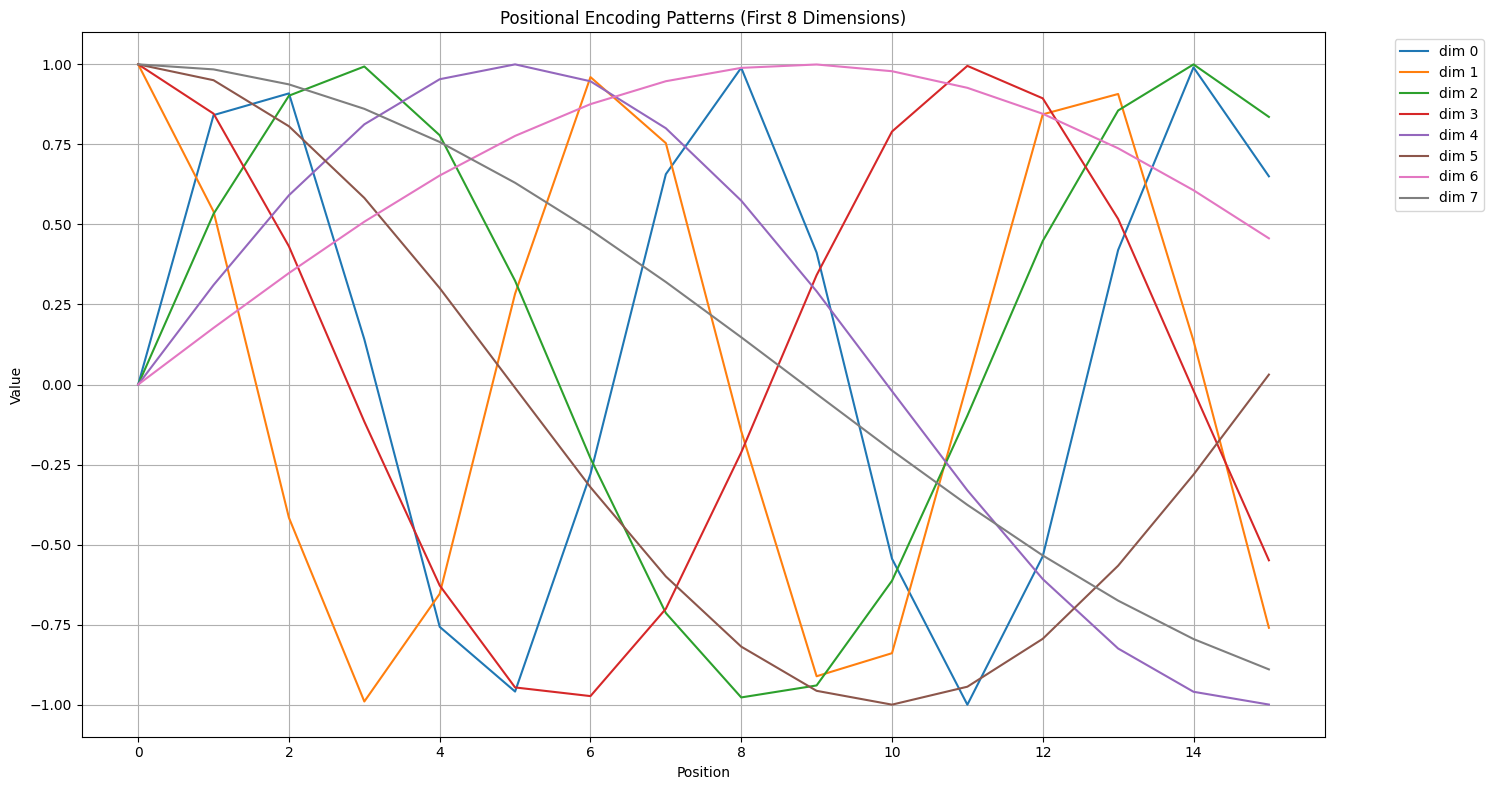

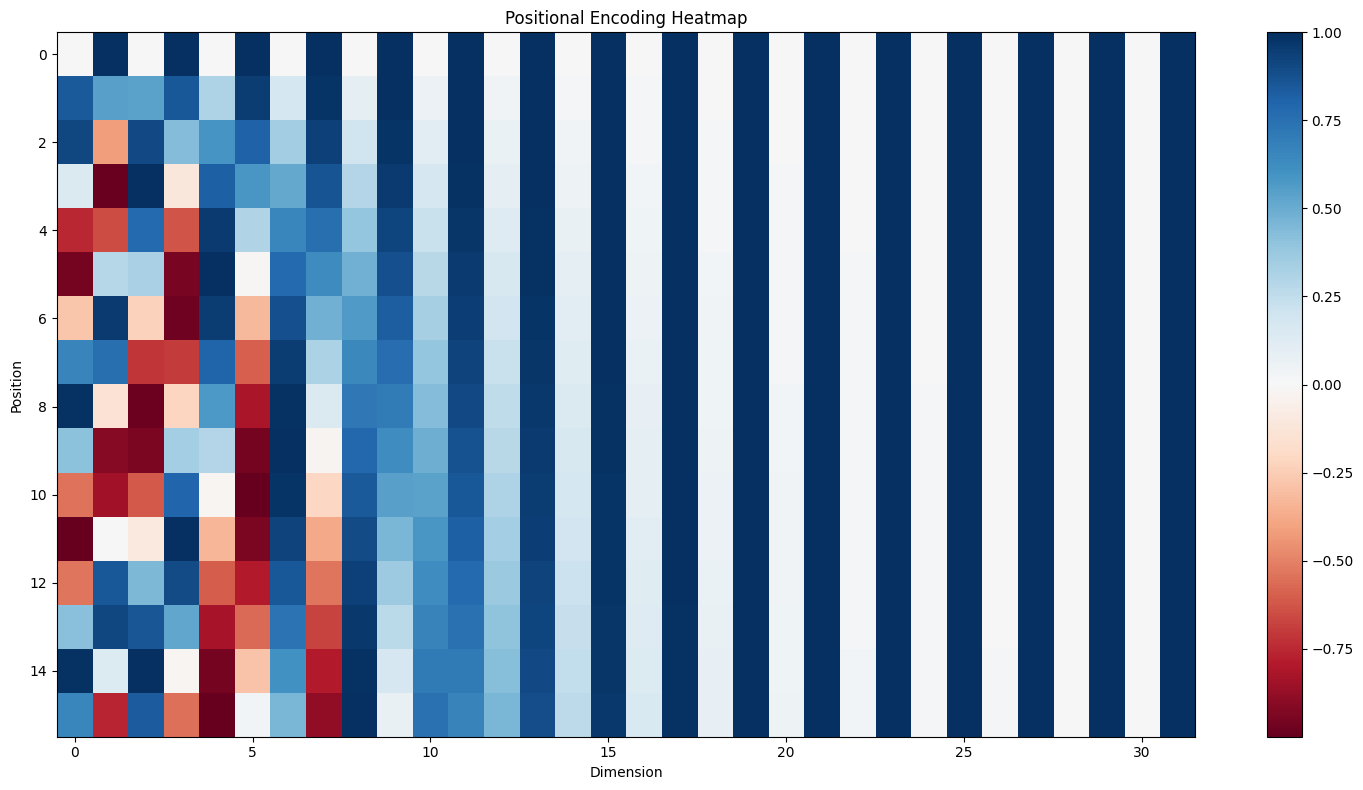

In [30]:
## Visualize positional encoding
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import matplotlib.pyplot as plt
import numpy as np

def visualize_positional_encoding(seq_length=30, d_model=32):
    # Generate positional encoding
    pe = np.zeros((seq_length, d_model))
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)

    # Create visualization
    plt.figure(figsize=(15, 8))

    # Plot first 8 dimensions
    for dim in range(8):
        plt.plot(pe[:, dim], label=f'dim {dim}')

    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.title('Positional Encoding Patterns (First 8 Dimensions)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Also show heatmap of all dimensions
    plt.figure(figsize=(15, 8))
    plt.imshow(pe, cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding Heatmap')
    plt.tight_layout()
    plt.show()

# Using your model's positional encoding
seq_length = 16  # From your example
d_model = 768    # From your example

# You might want to use a smaller d_model for visualization
visualize_positional_encoding(seq_length=16, d_model=32)

Attention Pattern Visualization

In [31]:
def test_decoder_causal_masking():
    torch.manual_seed(42)

    # Test parameters
    batch_size = 2
    seq_length = 5
    d_model = 512
    d_ff = 2048
    num_heads = 8

    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()

    decoder_input = torch.randn(batch_size, seq_length, d_model)
    encoder_output = torch.randn(batch_size, seq_length, d_model)

    attention_scores = []

    def attention_hook(module, input, output):
        if not attention_scores:
            # Apply softmax to get actual attention probabilities
            scores = F.softmax(module.att_matrix, dim=-1)
            attention_scores.append(scores.detach())

    decoder.att.register_forward_hook(attention_hook)

    with torch.no_grad():
        output = decoder(decoder_input, encoder_output)

    att_weights = attention_scores[0]

    print("\nAttention Matrix Shape:", att_weights.shape)

    # Print attention pattern for first head of first batch
    print("\nAttention Pattern (first head):")
    print(att_weights[0, 0].round(decimals=4))

    # Check future tokens (should be 0)
    future_attention = att_weights[:, :, torch.triu_indices(seq_length, seq_length, offset=1)[0],
                                        torch.triu_indices(seq_length, seq_length, offset=1)[1]]

    print("\nFuture Token Analysis:")
    print(f"Mean attention to future tokens: {future_attention.mean():.8f}")
    print(f"Max attention to future tokens: {future_attention.max():.8f}")
    print("Causal masking working:", "Yes" if future_attention.mean() < 1e-7 else "No")

    # Check present/past tokens
    present_past = att_weights[:, :, torch.tril_indices(seq_length, seq_length)[0],
                                    torch.tril_indices(seq_length, seq_length)[1]]

    print("\nPresent/Past Token Analysis:")
    print(f"Mean attention to present/past tokens: {present_past.mean():.4f}")
    print(f"Has non-zero attention patterns:", "Yes" if present_past.mean() > 0 else "No")

    # Verify each position's attention sums to 1
    attention_sums = att_weights.sum(dim=-1)
    print("\nAttention Sum Analysis:")
    print(f"Mean attention sum (should be 1): {attention_sums.mean():.4f}")
    print(f"Max deviation from 1: {(attention_sums - 1).abs().max():.8f}")

    return att_weights

attention_weights = test_decoder_causal_masking()


Attention Matrix Shape: torch.Size([2, 8, 5, 5])

Attention Pattern (first head):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4465, 0.5535, 0.0000, 0.0000, 0.0000],
        [0.3403, 0.3496, 0.3101, 0.0000, 0.0000],
        [0.1965, 0.3485, 0.1174, 0.3377, 0.0000],
        [0.1563, 0.1571, 0.1859, 0.1948, 0.3059]])

Future Token Analysis:
Mean attention to future tokens: 0.00000000
Max attention to future tokens: 0.00000000
Causal masking working: Yes

Present/Past Token Analysis:
Mean attention to present/past tokens: 0.3333
Has non-zero attention patterns: Yes

Attention Sum Analysis:
Mean attention sum (should be 1): 1.0000
Max deviation from 1: 0.00000012


In [33]:
def test_decoder_cross_attention():
    torch.manual_seed(42)

    # Test parameters
    batch_size = 2
    decoder_seq_len = 5
    encoder_seq_len = 7  # Different length to make it interesting!
    d_model = 512
    d_ff = 2048
    num_heads = 8

    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()

    # Create input sequences
    decoder_input = torch.randn(batch_size, decoder_seq_len, d_model)
    encoder_output = torch.randn(batch_size, encoder_seq_len, d_model)

    # Store attention scores
    cross_attention_scores = []

    def attention_hook(module, input, output):
        # We want the second call to att (cross-attention)
        if len(cross_attention_scores) < 2:
            scores = F.softmax(module.att_matrix, dim=-1)
            cross_attention_scores.append(scores.detach())

    decoder.att.register_forward_hook(attention_hook)

    # Forward pass
    with torch.no_grad():
        output = decoder(decoder_input, encoder_output)

    # Get cross-attention weights (second element in list)
    cross_att_weights = cross_attention_scores[1]  # [batch, heads, decoder_seq_len, encoder_seq_len]

    print("\nCross-Attention Matrix Shape:", cross_att_weights.shape)

    # Print attention pattern for first head of first batch
    print("\nCross-Attention Pattern (first head):")
    print(cross_att_weights[0, 0].round(decimals=4))

    # Verify each decoder position attends to all encoder positions
    attention_sums = cross_att_weights.sum(dim=-1)
    zero_attention = (cross_att_weights == 0).all(dim=-1)

    print("\nCross-Attention Analysis:")
    print(f"Mean attention weight: {cross_att_weights.mean():.4f}")
    print(f"Min attention weight: {cross_att_weights.min():.4f}")
    print(f"Max attention weight: {cross_att_weights.max():.4f}")

    print("\nAttention Coverage:")
    print(f"Each position's attention sums to 1: {torch.allclose(attention_sums, torch.ones_like(attention_sums))}")
    print(f"Every decoder position attends to some encoder position: {not zero_attention.any()}")

    # Check attention distribution
    attention_entropy = -(cross_att_weights * torch.log(cross_att_weights + 1e-9)).sum(dim=-1).mean()
    print(f"\nAttention entropy (higher means more uniform attention): {attention_entropy:.4f}")

    return cross_att_weights

cross_attention_weights = test_decoder_cross_attention()


Cross-Attention Matrix Shape: torch.Size([2, 8, 5, 7])

Cross-Attention Pattern (first head):
tensor([[0.1308, 0.1502, 0.1380, 0.1131, 0.1987, 0.1117, 0.1576],
        [0.1303, 0.1041, 0.1502, 0.1756, 0.1679, 0.1589, 0.1130],
        [0.0896, 0.2159, 0.1142, 0.1718, 0.1797, 0.0844, 0.1444],
        [0.1250, 0.1650, 0.1607, 0.1053, 0.0868, 0.2349, 0.1223],
        [0.1637, 0.0842, 0.2093, 0.1223, 0.1274, 0.1392, 0.1540]])

Cross-Attention Analysis:
Mean attention weight: 0.1429
Min attention weight: 0.0389
Max attention weight: 0.4142

Attention Coverage:
Each position's attention sums to 1: True
Every decoder position attends to some encoder position: True

Attention entropy (higher means more uniform attention): 1.8917


In [36]:
def test_decoder_cross_attention_with_padding():
    torch.manual_seed(42)

    # Test parameters
    batch_size = 2
    decoder_seq_len = 5
    encoder_seq_len = 7
    d_model = 512
    d_ff = 2048
    num_heads = 8

    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()

    # Create input sequences
    decoder_input = torch.randn(batch_size, decoder_seq_len, d_model)
    encoder_output = torch.randn(batch_size, encoder_seq_len, d_model)

    # Create padding mask for encoder outputs
    # Mask out last 2 positions (as if they were padding in encoder output)
    padding_mask = torch.ones(batch_size, decoder_seq_len, encoder_seq_len)
    padding_mask[:, :, -2:] = float('-inf')  # Mask positions 5,6
    padding_mask = padding_mask.unsqueeze(1)  # Add head dimension [batch, 1, decoder_seq, encoder_seq]

    cross_attention_scores = []

    def attention_hook(module, input, output):
        if len(cross_attention_scores) < 2:
            scores = F.softmax(module.att_matrix, dim=-1)
            cross_attention_scores.append(scores.detach())

    decoder.att.register_forward_hook(attention_hook)

    # Forward pass
    with torch.no_grad():
        output = decoder(decoder_input, encoder_output, padding_mask)

    # Get cross-attention weights (second element)
    cross_att_weights = cross_attention_scores[1]

    print("\nCross-Attention Matrix Shape:", cross_att_weights.shape)

    print("\nCross-Attention Pattern (first head):")
    print("(Last two encoder positions should have zero attention)")
    print(cross_att_weights[0, 0].round(decimals=4))

    # Analyze masked positions (last two columns)
    masked_attention = cross_att_weights[:, :, :, -2:]
    unmasked_attention = cross_att_weights[:, :, :, :-2]

    print("\nMasking Analysis:")
    print(f"Mean attention to masked positions: {masked_attention.mean():.8f}")
    print(f"Max attention to masked positions: {masked_attention.max():.8f}")
    print(f"Mean attention to unmasked positions: {unmasked_attention.mean():.4f}")

    # Verify attention still sums to 1 (only over unmasked positions)
    attention_sums = cross_att_weights.sum(dim=-1)

    print("\nAttention Coverage:")
    print(f"Each position's attention sums to 1: {torch.allclose(attention_sums, torch.ones_like(attention_sums), atol=1e-6)}")

    # Analyze attention distribution over unmasked positions
    print("\nUnmasked Position Analysis:")
    print(f"Min attention to unmasked positions: {unmasked_attention.min():.4f}")
    print(f"Max attention to unmasked positions: {unmasked_attention.max():.4f}")

    return cross_att_weights

# Run the test
cross_attention_weights = test_decoder_cross_attention_with_padding()


Cross-Attention Matrix Shape: torch.Size([2, 8, 5, 7])

Cross-Attention Pattern (first head):
(Last two encoder positions should have zero attention)
tensor([[0.1791, 0.2055, 0.1888, 0.1547, 0.2719, 0.0000, 0.0000],
        [0.1789, 0.1430, 0.2063, 0.2412, 0.2306, 0.0000, 0.0000],
        [0.1162, 0.2800, 0.1480, 0.2228, 0.2330, 0.0000, 0.0000],
        [0.1945, 0.2566, 0.2500, 0.1638, 0.1350, 0.0000, 0.0000],
        [0.2316, 0.1191, 0.2961, 0.1730, 0.1802, 0.0000, 0.0000]])

Masking Analysis:
Mean attention to masked positions: 0.00000000
Max attention to masked positions: 0.00000000
Mean attention to unmasked positions: 0.2000

Attention Coverage:
Each position's attention sums to 1: True

Unmasked Position Analysis:
Min attention to unmasked positions: 0.0458
Max attention to unmasked positions: 0.4875
